# Recruiter's Compensation Assistance Tool

## Defining problem statement

Predicting salary for a position is highly crucial in either talent acquisition team's perspective or job seeker's perspective. The main goal of this analysis is to predict the salary for a position based on various factors in recruiter's perspective. By the end of this analysis, we build a sophisticated mathematical model which can predict the salary for a job based on its features. For this analysis, we are going to use two million observations with various variables. We can discuss more on this in the following sections.


### Evaluation Methods

In this analysis, we use MSE(Mean Squared Error) as an evaluation metric to identify the predictive power of the developed mathematical model.

*If a vector of ***n*** predictions generated from a sample of n data points on all variables, and ***Y*** is the vector of observed values of the variable being predicted, then the within-sample MSE of the predictor is computed as*

> ${\displaystyle \operatorname {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}.}$

### About Data

In this section, we are going to discuss various topics such as loading data into the computational environment,  underlying distributions, exploratory analysis, and preprocessing of data.

Available features for this analysis are <br>
-  **JobId:** Job id for the role.<br>
-  **CompanyId:** Company id for the respective job id.<br>
-  **Degree:** Applicant's degree for the respective job id. <br>
-  **Major:** Specialization of major degree for the respective applicant.<br>
-  **Industry:** Job industry for the respective job id.<br>
-  **YearsOfExperience:** Required years of experience for the respective job id.<br>
-  **MilesFromMetropolis:** Distance between the work area and nearby metropolitan city.<br>
-  **Salary:** Salary in thousands for the respective job id.<br>

## Discover Data Insights

### Load the data 

In [2]:
#  import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.externals import joblib
import lightgbm as lgbm
sns.set()
%matplotlib inline

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

/Users/anilkumar/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
#  load the data into the environment

feature_file_path = '/Users/anilkumar/Anils/DSDJ/portfolio/Draft/SalaryPridiction/data/train_features.csv'
target_file_path = '/Users/anilkumar/Anils/DSDJ/portfolio/Draft/SalaryPridiction/data/train_salaries.csv'
test_file_path = '/Users/anilkumar/Anils/DSDJ/portfolio/Draft/SalaryPridiction/data/test_features.csv'
traget_col = 'salary'
common_col = 'jobId'

feat_df = pd.read_csv(feature_file_path)
tar_df = pd.read_csv(target_file_path)
test_df = pd.read_csv(test_file_path)
feature_df = pd.merge(feat_df, tar_df, on=common_col, how='inner')

feature_df.shape, feat_df.shape, tar_df.shape, test_df.shape

((1000000, 9), (1000000, 8), (1000000, 2), (1000000, 8))

In [5]:
# del(feat_df, tar_df)

***`Before doing any further analysis, let's understand the data by answering several questions.`***

##### Do we have any missing values?

In [6]:
# Total number of null values in the feature dataset
feature_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [7]:
# Total number of null values in the test dataset
test_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

 Well! There are `no missing values` in given train and test datasets.

##### How many unique values we have for each category?

In [8]:
# number of unique features in the feature dataset
feature_df.nunique()

jobId                  1000000
companyId                   63
jobType                      8
degree                       5
major                        9
industry                     7
yearsExperience             25
milesFromMetropolis        100
salary                     280
dtype: int64

It looks like `jobId` feature has unique values in the dataset as the number of observations is equal to the number of unique values. `CompanyId` feature has `63`, `jobType` feature has `8`, `degree` feature has `5`, `major` feature has `9`, `industry` feature has `7`, `yearsExperience` feature has `25` and `milesFromMetropolis` feature has `100` unique values.

##### What kind of features exists? How does data look like?

In [9]:
# let's look into the data types in data
feature_df.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

It looks like we have both categorical and numerical values, `jobId, companyID, jobType, degree, major, industry` features are having categorical observations and `yearsExperience, milesFromMetropolis, salary` features are numerical observations.<br>
<br>
Let's look at few rows of data.

In [10]:
# first 3 row of data
feature_df.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137


Now the type of data from the previous table makes sense.<br>

As per problem definition, we understand that we are going to predict the salary. We need to clean the dataset further based on this target feature.<br>

##### Do we have any observations with salary 0?

In [11]:
# Check for salary 0

len(feature_df[feature_df['salary'] ==0])

5

In [12]:
# observations with salary is zero
feature_df[feature_df['salary'] ==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


OOOPS! There are 5 rows with a salary equal to  **$0.00 USD**. When we look at the data, these observations are not realistic and doesn't make sense to have them in the dataset. We are removing these observations since the count is very less and negligible.



##### What is the distribution of the target feature?

Text(0.5, 0.98, 'Distribution of salary')

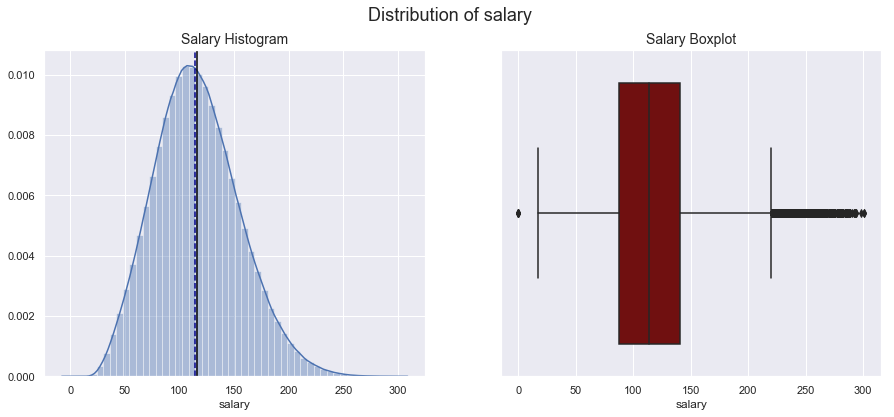

In [13]:
# plot salary distributions
f, ax = plt.subplots(1,2,figsize=(15,6))
sns.distplot(feature_df['salary'], ax=ax[0], kde=True, norm_hist=True)
ax[0].axvline(np.mean(feature_df['salary']), color='black')
ax[0].axvline(np.median(feature_df['salary']), color='darkblue', linestyle='--')
ax[0].set_title('Salary Histogram',fontsize=14)
sns.boxplot(feature_df['salary'], ax=ax[1], color='maroon')
ax[1].set_title('Salary Boxplot',fontsize=14)
f.suptitle('Distribution of salary', fontsize=18)

When we see the salary distributions in the histogram plot, we can observe the data is slightly skewed to the right. Mean and median have lied around 120. At the same time, the box plot shows that there are more values lied after the right whisker of the box plot. We need to examine those values and should treat them before going for further analysis if they are outliers or not.

##### Are they outliers?


In [14]:
#  find the IQR
def outlier_finder(x):
    x = sorted(x)
    first_quant, med_val, third_quant = np.percentile(x, [25,50,75])
    IQR = third_quant-first_quant
    lower_bound = first_quant-1.5*IQR
    upper_bound = third_quant+1.5*IQR
    print(f'The lower bound value is: {lower_bound}')
    print(f'The upper bound value is: {upper_bound}')
    print(f'The IQR value is: {IQR}')
    print(f'The 25% value is: {first_quant}')
    print(f'The 75% bound value is: {third_quant}')
    print(f'The median value is :{med_val}')
    
    print(f'\n***NOTE: Please examine the values lied above the upper bound values before considering them as outliers.')
    
    return lower_bound, first_quant, med_val, third_quant, upper_bound


In [15]:
# determine the IQR for featuer dataset
outlier_finder(feature_df['salary'])

The lower bound value is: 8.5
The upper bound value is: 220.5
The IQR value is: 53.0
The 25% value is: 88.0
The 75% bound value is: 141.0
The median value is :114.0

***NOTE: Please examine the values lied above the upper bound values before considering them as outliers.


(8.5, 88.0, 114.0, 141.0, 220.5)

In [16]:
# print number of observations lied below the lower limit and above the upper limit

print(f' There are {len(feature_df[feature_df["salary"] < 8.5])} rows in the dataset below the lower bound of the salary(According to IQR).')

print(f' There are {len(feature_df[feature_df["salary"] > 220.5])} rows in the dataset below the lower bound of the salary(According to IQR).')



 There are 5 rows in the dataset below the lower bound of the salary(According to IQR).
 There are 7117 rows in the dataset below the lower bound of the salary(According to IQR).


Well! There are 5 observations below the lower bound limit, but we have 7177 observations above the upper bound limit. Let's look at those values.


In [17]:
feature_df[feature_df['salary'] > 220.5]['jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

Based on the above table, executive level, middle and senior-level positions have salaries more than `220K+` is reasonable, but junior level employees also have 220K+ salaries. This criterion needs a check for significance.

In [18]:
# Observations above the upper bound
feature_df[(feature_df['salary'] > 220.5) & (feature_df['jobType']=='JUNIOR')].sort_values(by='salary', ascending=False)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
743326,JOB1362685151013,COMP14,JUNIOR,DOCTORAL,BUSINESS,FINANCE,19,0,236
787674,JOB1362685195361,COMP43,JUNIOR,DOCTORAL,BUSINESS,FINANCE,18,15,232
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
796956,JOB1362685204643,COMP30,JUNIOR,MASTERS,BUSINESS,OIL,24,2,228
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


Though those observations jobType is junior, all of them are having either `DOCTORAL` or `MASTERS` degree. Every employee has decent amount of experiance and also they are working in `FINANCE` or `OIL` industry. Generally, employees who are working in those industries tend to get good salaries these values look reasonable. Let's check for other criterias. 

In [19]:
# Industry-wise counts(Number of observations) who are having 220K+ salaries
feature_df[feature_df['salary'] > 220.5]['industry'].value_counts()

OIL          2368
FINANCE      2200
WEB          1280
HEALTH        631
AUTO          325
SERVICE       200
EDUCATION     113
Name: industry, dtype: int64

There are 113 observations in the `EDUCATION` industry. Generally, the education industry doesn't pay much until and unless they are in executive-level positions. Let's examine.


In [20]:
# Education industry-wise counts(Number of observations) who are having 220K+ salaries
feature_df[(feature_df['salary'] > 220.5) & (feature_df['industry']=='EDUCATION')]['jobType'].value_counts()

CEO               80
CTO               17
CFO               15
VICE_PRESIDENT     1
Name: jobType, dtype: int64

Yes, all observation's `jobType` is an executive role and this is the realistic scenario.

In [21]:
# Degree-wise counts(Number of observations) who are having 220K+ salaries
feature_df[feature_df['salary'] > 220.5]['degree'].value_counts()

DOCTORAL       2981
MASTERS        2134
BACHELORS      1440
HIGH_SCHOOL     354
NONE            208
Name: degree, dtype: int64

Surprisingly, there are 208 observations that doesn't have any degree (not even high school) are getting paid more than 220K USD. This scenario is interesting. Let's dig more into this.

In [22]:
# NO Degree counts(Number of observations) who are having 220K+ salaries
feature_df[(feature_df['salary'] > 220.5) & (feature_df['degree']=='NONE')]['jobType'].value_counts()

CEO               124
CFO                41
CTO                35
VICE_PRESIDENT      8
Name: jobType, dtype: int64

Hmmm! All observations are in executive roles and let's see what kind of industries they are into.

In [23]:
# NO Degree counts(Number of observations) with industries who are having 220K+ salaries
feature_df[(feature_df['salary'] > 220.5) & (feature_df['degree']=='NONE')]['industry'].value_counts()

OIL        82
FINANCE    81
WEB        29
HEALTH     10
AUTO        5
SERVICE     1
Name: industry, dtype: int64

Fair enough. Most of the observations are in `OIL, FINANCE` and `WEB` industries. These observations make sense to me.<br>

Let's check other variable's relation with the target variable.

##### What is the relationship between the target feature and other independent variables?

In [24]:
# function to draw mean plot and box plot or boxen plot 
def plot_box_mean(df, col):
    plt.figure(figsize = (14, 8))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category').copy()
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=30)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    if col == 'companyId':
        sns.boxplot(x=col, y='salary', data=df)
        plt.xticks(rotation=90)
    elif df[col].dtype == 'category':
        sns.boxenplot(x = col, y = 'salary', data=df)
        plt.xticks(rotation=30)
    plt.ylabel('Salaries')
    plt.show()

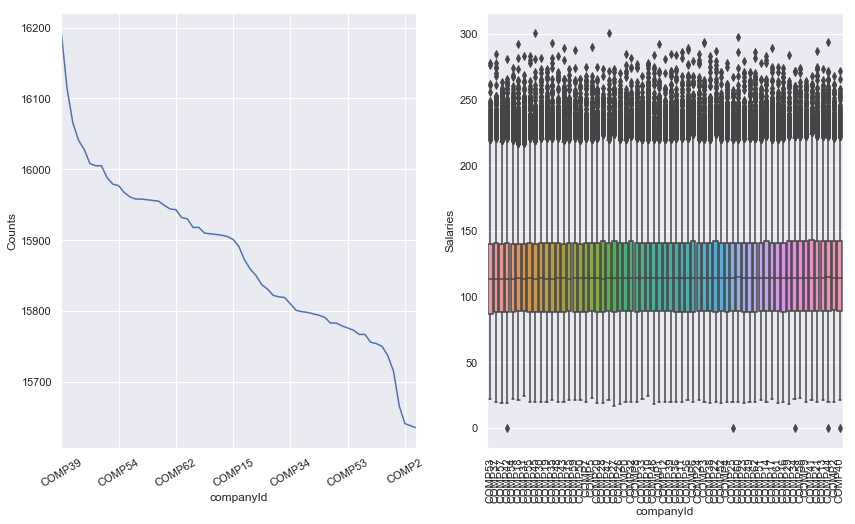

In [25]:
# pLot companyID and salary
plot_box_mean(feature_df, 'companyId')

As per the data description, each company id represents a company. When we examine the **Company Id** feature, it has 63 unique observations. When we look at distributions of this feature, the mean salary for each company  is the same. Also, the number of observations for each company has same values; all the data is uniformly distributed and did not give more information.

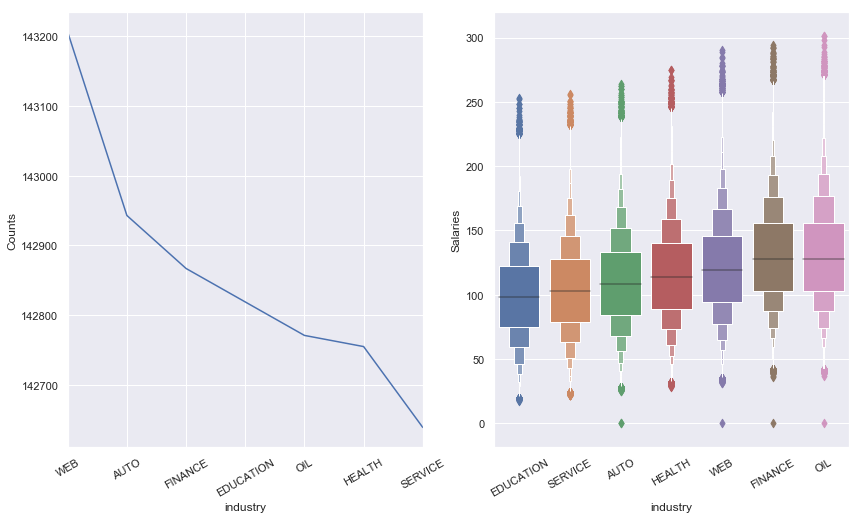

In [26]:
# plot the relationship between industry and salary
plot_box_mean(feature_df, 'industry')


***From the plots, we can conclude that there is a positive linear correlation between industry and salary features.***

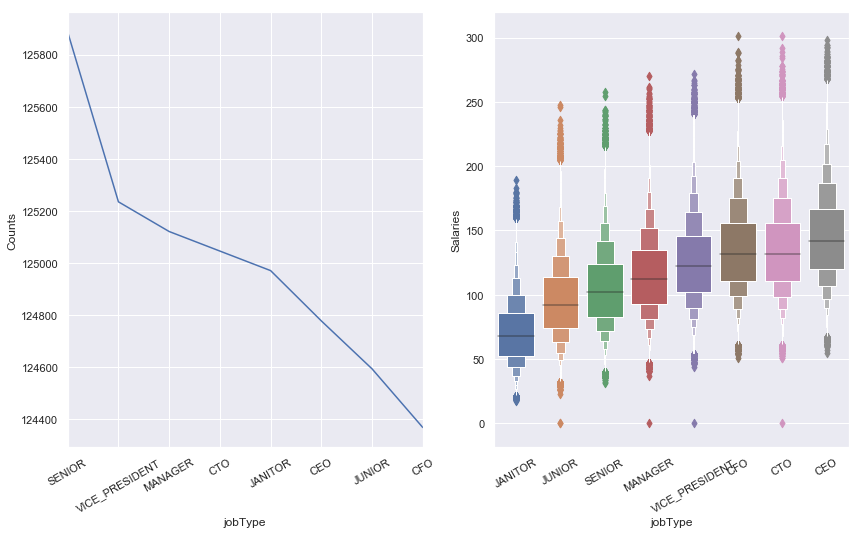

In [27]:
# plot the relationship between job type and salary
plot_box_mean(feature_df, 'jobType')

***From the plots we can conclude that there is a positive linear correlation between job type and salary features. This looks realistic and makes sense as generally janitors get paid much lesser than CEOs.***

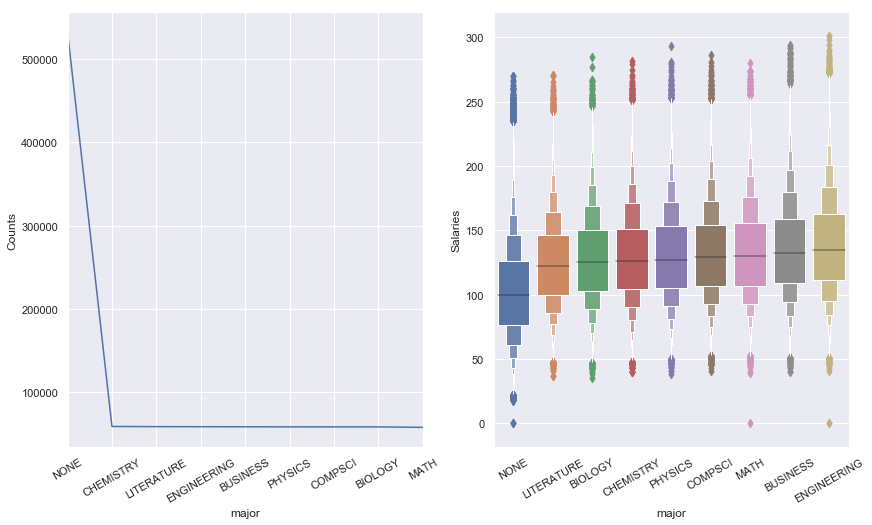

In [28]:
# plot the relationship between major and salary
plot_box_mean(feature_df, 'major')

***From the plots we can conclude that there is a positive linear correlation between major and salary features. Certainly, engineers are well paid than the people who don't have a major degree.***

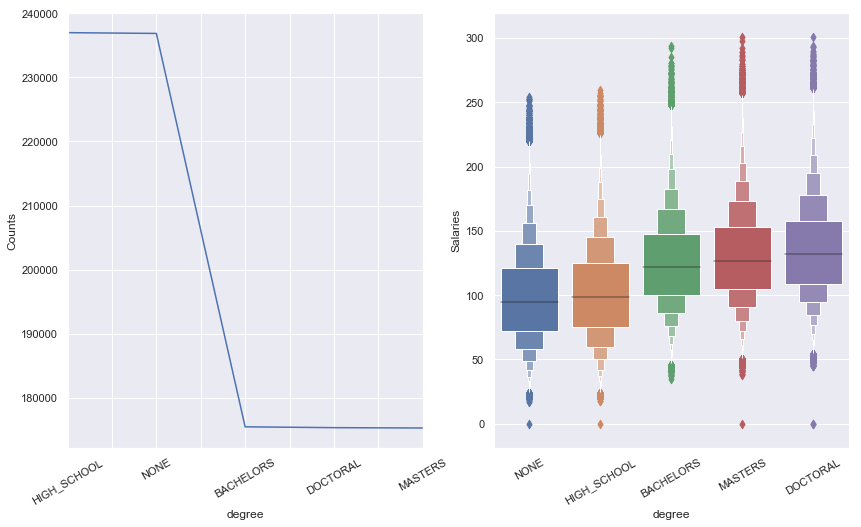

In [29]:
# plot the relationship between degree and salary
plot_box_mean(feature_df, 'degree')

***From the plots we can conclude that there is a positive linear correlation between degree and salary features. For apparent reasons, Ph.D. scholars get more pay than no degree holders.***

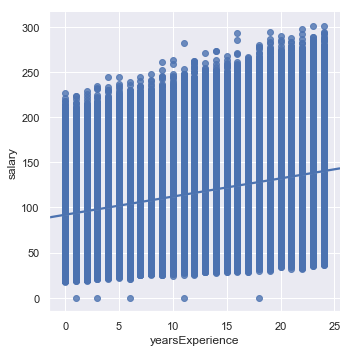

In [30]:
# plot the relationship between years experience and salary
sns.lmplot(x='yearsExperience', y='salary', data = feature_df)

***The `lm plot` shows that there is a clear linear relationship between salary and years of experience. If Years of experience increases, salary also increases.***

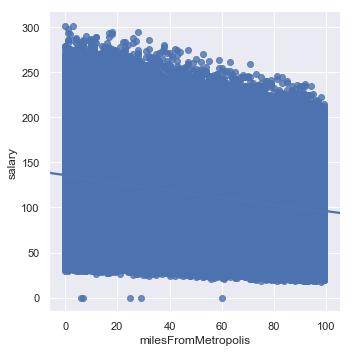

In [31]:
# plot the relationship between miles from metro and salary
sns.lmplot(x='milesFromMetropolis', y='salary', data = feature_df)

***The `lm plot` shows that there is a clear linear relationship between salary and miles from metropolis. The far from the metro, the less pay we get.***

##### Final data clean and split variables

In [32]:
# lets get rid off JobID and observations below the lower bound

feature_df = feature_df.drop('jobId', axis=1)
test_df = test_df.drop('jobId', axis=1)
feature_df = feature_df[feature_df['salary'] > 8.5]


In [33]:
# lets split the data into dependent variables and independent variables

features = feature_df.drop('salary', axis=1)
target = feature_df['salary']

features.shape, target.shape

((999995, 7), (999995,))

In [34]:
# Garbage collection to freeup RAM space
import gc
gc.collect()

16049

In [35]:
# Create dummie features
features = pd.get_dummies(features)
features.shape

(999995, 94)

## Developing Model

We have cleaned, preprocessed and features separated dataset. Let's start building the model.<br>
<br>
### Base Line Model
As part of creating a baseline model, I have chosen `Random Forest Regressor` as this is the gateway algorithm for any machine learning model. Since it is very less prone to overfit and has very less assumption when compared with `Linear Regression.`<br>
<br>
Before building models, let split the data into train and validation set.

In [36]:
# split the data into train and validation sets
feature_train, feature_valid, target_train, target_valid = train_test_split(features, target, test_size=0.3, random_state=2019, shuffle=True)

In [37]:
# validating shapes of train and validation sets
feature_train.shape, feature_valid.shape, target_train.shape, target_valid.shape

((699996, 94), (299999, 94), (699996,), (299999,))

In [38]:
# building baseline model with random forest
rf = RandomForestRegressor(n_jobs=-1, n_estimators=120, verbose=5, max_depth=25, min_samples_split=60,max_features=30)
rf.fit(feature_train, target_train)
rf.score(feature_valid, target_valid)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 120building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120

building tree 9 of 120


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s


building tree 10 of 120
building tree 11 of 120
building tree 12 of 120building tree 13 of 120

building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120building tree 31 of 120

building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   45.7s


building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82 of 120
building tree 83 of 120
building tree 84 of 120
building tree 85 of 120
building tree 86 of 120
building tree 87 of 120
building tree 88 of 120
building tree 89 of 120
building tree 90 of 120
building tree 91 of 120
building tree 92 of 120
building tree 93 of 120
building tree 94 of 120
building tree 95 of 120
building tree 96 of 120
building tree 97 of 120
building tree 98 of 120
building tree 99 of 120
building tree 100 of 120
building tree 101 of 120
building tree 102 of 120
building tree 103 of 120
building tree 104 of 120
building tr

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    2.2s finished


0.7554359704556126

In [39]:
rf_preds = rf.predict(feature_valid)
mean_squared_error(rf_preds, target_valid)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    2.2s finished


366.9330612851257

As discussed in evaluation metric section, we will look for MSE. Our baseline model is giving the mean squared error as 366.90 and the model prediction accuracy is 76%. 

##### Can we improve this score and prediction accuracy?

Let's try for the below models and compare with baseline model if they can help us to find better MSE value and accuracy.
- Ridge
- Linear Regression
- Second-order Polynomial features with Linear Regression
- Gradient Descent
- LightGBM

In [40]:
# Ridge Regression
rg = Ridge()
rg.fit(feature_train, target_train)
rg.score(feature_valid, target_valid)

0.7432450892362962

In [41]:
rg_preds = rg.predict(feature_valid)
mean_squared_error(rg_preds, target_valid)

385.2237206838137

`Ridge` model mean squared error is higher than the baseline model and prediction power is lesser than the baseline model.


In [42]:
# Linear regression
lr = LinearRegression()
lr.fit(feature_train, target_train)
lr.score(feature_valid, target_valid)

0.7432450834238199

In [43]:
lr_preds = lr.predict(feature_valid)
mean_squared_error(lr_preds, target_valid)

385.22372940459627

`Linear Regression` model mean squared error is higher than the baseline model and prediction power is lesser than the baseline model.


In [44]:
# applying second order polynomial
p = PolynomialFeatures()
feature_train_p = p.fit_transform(feature_train)
feature_valid_p = p.fit_transform(feature_valid)

In [45]:
# Applying Linear Regression on polynomial features
lrp = LinearRegression()
lrp.fit(feature_train_p, target_train)
lrp.score(feature_valid_p, target_valid)

0.7628766222014541

In [46]:
lrp_preds = lrp.predict(feature_valid_p)
mean_squared_error(lrp_preds, target_valid)

355.7694362494062

Cool! We got better mean squared error which is lesser than the baseline model and better prediction power than the baseline model. We made some progress here and let's see if any other model can give us better results than this.


In [47]:
#  Applying gradient descent algorithm
gd = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=5)
gd.fit(feature_train, target_train)
gd.score(feature_valid, target_valid)

      Iter       Train Loss   Remaining Time 
         1        1350.7216           11.40m
         2        1229.2484           11.30m
         3        1128.8717           11.13m
         4        1045.3237           10.95m
         5         973.7605           10.84m
         6         913.7418           10.69m
         7         861.6513           10.59m
         8         813.8119           10.61m
         9         772.1818           10.61m
        10         735.4810           10.59m
        11         703.8882           10.55m
        12         672.8977           10.39m
        13         646.2392           10.33m
        14         621.6976           10.19m
        15         599.8408           10.11m
        16         580.2617           10.03m
        17         563.2002            9.99m
        18         547.5966            9.91m
        19         532.8465            9.82m
        20         520.0044            9.79m
        21         508.0239            9.72m
        2

0.7615728509868009

In [48]:
gd_preds = gd.predict(feature_valid)
mean_squared_error(gd_preds, target_valid)

357.7255569589779

`Gradient Descent Boost` algorithm gave better result than the baseline model but not better than polynomial featured regression values.

In [49]:
import lightgbm as lgbm
lgbm_train = lgbm.Dataset(feature_train, target_train)
lgbm_valid = lgbm.Dataset(feature_valid, target_valid)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 5,
    'n_estimators':160
    

}
lgb = lgbm.train(params,
                  lgbm_train,
                  num_boost_round=2000,
                  valid_sets=lgbm_valid,
                  early_stopping_rounds=50)

[1]	valid_0's l1: 29.6687	valid_0's l2: 1372.28
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l1: 28.2276	valid_0's l2: 1244.54
[3]	valid_0's l1: 27.2	valid_0's l2: 1153.81
[4]	valid_0's l1: 26.012	valid_0's l2: 1055.71
[5]	valid_0's l1: 24.8004	valid_0's l2: 960.356
[6]	valid_0's l1: 23.9304	valid_0's l2: 894.034
[7]	valid_0's l1: 23.0158	valid_0's l2: 826.297
[8]	valid_0's l1: 22.3492	valid_0's l2: 778.765
[9]	valid_0's l1: 21.605	valid_0's l2: 727.27
[10]	valid_0's l1: 21.0007	valid_0's l2: 686.343
[11]	valid_0's l1: 20.4974	valid_0's l2: 652.654
[12]	valid_0's l1: 19.9424	valid_0's l2: 617.041
[13]	valid_0's l1: 19.4877	valid_0's l2: 588.842
[14]	valid_0's l1: 19.0583	valid_0's l2: 562.616
[15]	valid_0's l1: 18.6957	valid_0's l2: 540.943
[16]	valid_0's l1: 18.3953	valid_0's l2: 522.871
[17]	valid_0's l1: 18.1144	valid_0's l2: 506.776
[18]	valid_0's l1: 17.8661	valid_0's l2: 492.578
[19]	valid_0's l1: 17.631	valid_0's l2: 479.422
[20]	valid_0's l1: 17.4

In [50]:
lgb_preds = lgb.predict(feature_valid, num_iteration=lgb.best_iteration)
mean_squared_error(target_valid, lgb_preds) 

357.2627599272048

In [51]:
feature_importances = pd.DataFrame({'FeatureName':features.columns, 'Importance':lgb.feature_importance()})

`LightGBM` algorithm gave better result than the baseline model but not better than polynomial featured regression values.

In [52]:
ss = StandardScaler()
feature_importances['Importance'] = ss.fit_transform(feature_importances['Importance'].values.reshape(94,1))
feature_importances.sort_values(by='Importance', ascending=False)[:10]

,FeatureName,Importance
1,milesFromMetropolis,6.704372
0,yearsExperience,5.344635
87,industry_EDUCATION,1.133335
93,industry_OIL,0.993476
72,jobType_CEO,0.985706
92,industry_FINANCE,0.962396
90,industry_HEALTH,0.822538
88,industry_SERVICE,0.806998
71,jobType_CTO,0.721529
66,jobType_JUNIOR,0.698219



The above table represents the top 10 features of a given dataset.<br>

`LightGBM` algorithm gave second best results in the list of the models applied to the given dataset.<br>

Since LightGBM and second order polynomials are the best two models, we have right now. 


Let's see if some feature engineering helps us to improve the MSE value.<br>
My idea is to create new features based on all the categorical features as follows.<br>
- Group all the categorical variables.
- Calculate the basic statistics such as mean, median, standard deviation, min and max values.
- Broadcast those values across the dataset based on categorical columns.

In [53]:
# define a function to calculate the group stats based on column and return a dataframe
def grp_stats(df,cat_cols, p_col):
    yr_stats = pd.DataFrame(columns=['grp_mean', 'grp_median', 'grp_max', 'grp_min', 'grp_std'])
    yr_stats['grp_mean'] = df.groupby(cat_cols)[p_col].mean()
    yr_stats['grp_median'] = df.groupby(cat_cols)[p_col].median()
    yr_stats['grp_max'] = df.groupby(cat_cols)[p_col].max()
    yr_stats['grp_min'] = df.groupby(cat_cols)[p_col].min()
    yr_stats['grp_std'] = df.groupby(cat_cols)[p_col].std()
    return yr_stats


In [54]:
# creating cataegory column list
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']

# calculate group stats
yr_grp_stats= grp_stats(feature_df, cat_cols, 'salary')

# merge group stats into features 
new_features =pd.merge(feature_df, yr_grp_stats, on=cat_cols, how='left')

# merge group stats into test set 
test_df = pd.merge(test_df, yr_grp_stats, on=cat_cols, how='left')

# remove target column
new_features.drop(['salary', ], axis=1, inplace=True)

In [55]:
# checking for null values
new_features.isna().sum(), test_df.isnull().sum()

(companyId                0
 jobType                  0
 degree                   0
 major                    0
 industry                 0
 yearsExperience          0
 milesFromMetropolis      0
 grp_mean                 0
 grp_median               0
 grp_max                  0
 grp_min                  0
 grp_std                921
 dtype: int64, companyId                 0
 jobType                   0
 degree                    0
 major                     0
 industry                  0
 yearsExperience           0
 milesFromMetropolis       0
 grp_mean                908
 grp_median              908
 grp_max                 908
 grp_min                 908
 grp_std                6666
 dtype: int64)

In [56]:
# replacing null values with 0's
new_features['grp_std'].fillna(0, inplace=True)
test_df['grp_mean'].fillna(0, inplace=True)
test_df['grp_median'].fillna(0, inplace=True)
test_df['grp_max'].fillna(0, inplace=True)
test_df['grp_min'].fillna(0, inplace=True)
test_df['grp_std'].fillna(0, inplace=True)



In [57]:
# Check for null values after filling null vlaues with 0's
new_features.isnull().sum(), test_df.isnull().sum()


(companyId              0
 jobType                0
 degree                 0
 major                  0
 industry               0
 yearsExperience        0
 milesFromMetropolis    0
 grp_mean               0
 grp_median             0
 grp_max                0
 grp_min                0
 grp_std                0
 dtype: int64, companyId              0
 jobType                0
 degree                 0
 major                  0
 industry               0
 yearsExperience        0
 milesFromMetropolis    0
 grp_mean               0
 grp_median             0
 grp_max                0
 grp_min                0
 grp_std                0
 dtype: int64)

This time let's build only two best models that are lightGBM and polynomial Linear Regression models.

In [58]:
# creating dummies for new featured columns
new_features = pd.get_dummies(new_features)
test_df = pd.get_dummies(test_df)
new_feature_train, new_feature_valid, target_train, target_valid = train_test_split(new_features, target, test_size=0.3, random_state=2019, shuffle=True)

In [59]:
# lightGBM model
lgbm_train = lgbm.Dataset(new_feature_train, target_train)
lgbm_valid = lgbm.Dataset(new_feature_valid, target_valid)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 5,
    'n_estimators':160
    

}
new_lgb = lgbm.train(params,
                  lgbm_train,
                  num_boost_round=2000,
                  valid_sets=lgbm_valid,
                  early_stopping_rounds=50)

[1]	valid_0's l1: 28.9542	valid_0's l2: 1308.72
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l1: 27.0218	valid_0's l2: 1138.59
[3]	valid_0's l1: 25.3222	valid_0's l2: 999.912
[4]	valid_0's l1: 23.9664	valid_0's l2: 894.194
[5]	valid_0's l1: 22.9994	valid_0's l2: 822.078
[6]	valid_0's l1: 21.8288	valid_0's l2: 737.805
[7]	valid_0's l1: 20.9417	valid_0's l2: 677.382
[8]	valid_0's l1: 20.0446	valid_0's l2: 618.262
[9]	valid_0's l1: 19.2703	valid_0's l2: 569.237
[10]	valid_0's l1: 18.7029	valid_0's l2: 534.919
[11]	valid_0's l1: 18.1066	valid_0's l2: 499.984
[12]	valid_0's l1: 17.6936	valid_0's l2: 476.681
[13]	valid_0's l1: 17.2404	valid_0's l2: 451.416
[14]	valid_0's l1: 16.8492	valid_0's l2: 430.282
[15]	valid_0's l1: 16.6495	valid_0's l2: 420.223
[16]	valid_0's l1: 16.336	valid_0's l2: 404.4
[17]	valid_0's l1: 16.0694	valid_0's l2: 391.353
[18]	valid_0's l1: 15.8856	valid_0's l2: 382.834
[19]	valid_0's l1: 15.6755	valid_0's l2: 373.144
[20]	valid_0's l1: 

In [60]:
# predicting values on validation set
new_lgb_preds = new_lgb.predict(new_feature_valid, num_iteration=lgb.best_iteration)
mean_squared_error(target_valid, new_lgb_preds) 

308.68906961462534

In [ ]:
# LightGBM sklearn version
from lightgbm import LGBMRegressor


sklgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=40,
                      learning_rate=0.1, feature_fraction=0.8, bagging_fraction=0.9,
                      bagging_freq=5, verbose=-1, n_estimators=160)


sklgbm.fit(new_feature_train, target_train)
sklgbm.score(new_feature_valid, target_valid)

0.7943435431482876

In [ ]:
sklgb_preds = sklgbm.predict(new_feature_valid)
mean_squared_error(target_valid, sklgb_preds)

308.5578587588453

In [ ]:
# applying second order polynomial
p = PolynomialFeatures()
new_feature_train_p = p.fit_transform(new_feature_train)
new_feature_valid_p = p.fit_transform(new_feature_valid)

In [ ]:
# applying Linear Regression on polynomial features
lrpn = LinearRegression()
lrpn.fit(new_feature_train_p, target_train)
lrpn.score(new_feature_valid_p, target_valid)



0.7911523055083696

In [ ]:
new_lrp_preds = lrpn.predict(new_feature_valid_p)
mean_squared_error(target_valid, new_lrp_preds )

313.3458506752564

`LightGBM` model gave the best result and outperformed all other models, including second-order polynomial Linear regression. So, we choose the LightGBM as our final model.<br>

Let's train the model with aggregate data then we can save the model.  Later we can use the saved model to predict the salary for test set observations.

In [ ]:
# building feature importance table
feat_imp =pd.DataFrame({'features':new_feature_train.columns, 'Importance':sklgbm.feature_importances_})

feat_imp.to_csv('Feature_Importance.csv')

Text(0.5, 1.0, 'Top 10 Important Features')

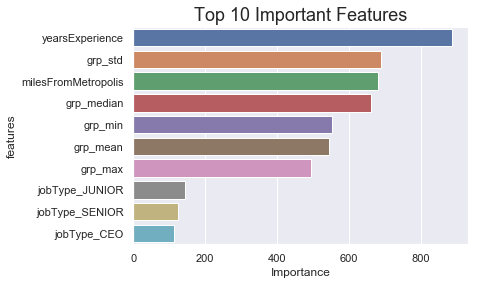

In [ ]:
# sort the feature importance table by importance and plot the top 10 important features
feat_imp= feat_imp.sort_values(by='Importance' ,ascending=False)

feat_imp[:10]

sns.barplot(x='Importance', y='features', data=feat_imp[:10], orient='h')
plt.title('Top 10 Important Features', fontsize=18)


The developed mathematical model predicts that `yearsExperience` is the best feature followed by `Group Standard Deviation` and `milesFromMetropolis` are the top three features to predict the salaries. 


## Deploying the Model

##### Let's create a pipe line to automate the process

In [ ]:
# Create pipe line with standard process to follow
p_input = [('Scale', StandardScaler()), ('Model', LGBMRegressor(boosting_type='gbdt',
                                                                objective='regression',
                                                                num_leaves=40,
                                                                learning_rate=0.1,
                                                                feature_fraction=0.8,
                                                                bagging_fraction=0.9,
                                                                bagging_freq=5,
                                                                verbose=-1,
                                                                n_estimators=160))]
pipeline = Pipeline(p_input)

In [ ]:
# Fit the model
pipe_Lgbm = pipeline.fit(new_features, target)
pipe_Lgbm.score(new_features, target)

0.797265778860194

In [ ]:
# dump the model
fileName = 'Recruiter_Assistance_Model.txt'
joblib.dump(pipe_Lgbm, fileName)

# load the model
raModel = joblib.load(fileName)

#  predictions on validation set to check saved & reloaded model is working as expected
p_pred = raModel.score(new_feature_valid, target_valid)
p_pred

0.7969280588703129

#####  Predicting test data salaries

In [ ]:
predictions = raModel.predict(test_df)

In [ ]:
# Saving the predictions
np.savetxt('Predictions.csv', predictions, delimiter=',')

## Final thoughts

Finally, lightGBM has given the best results.<br>

##### Future work scope
Below are the points I haven't considered for this analysis and may help us to improve the MSE and prediction power.

- More feature engineering.
- Converting numerical values into categories by dividing into several groups.
- Running for more complex model and more optimization.
- Another level of hyperparameter tuning.


